<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><span><a href="#Resampling-by-One-Hour" data-toc-modified-id="Resampling-by-One-Hour-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><b>Resampling by One Hour</b></a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Checklist" data-toc-modified-id="Checklist-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Checklist</a></span></li></ul></div>

##  Taxi orders forecasting.

The company "Chetenykoe taxi" has collected historical data on taxi orders at airports. In order to attract more drivers during peak loads, it is necessary to predict the number of taxi orders for the next hour. Build a model for such prediction.

The RMSE metric value on the test set should be no more than 48.

You need to:

1. Load the data and resample it hourly.
2. Analyze the data.
3. Train different models with various hyperparameters. Make the test set size 10% of the original data.
4. Test the data on the test set and draw conclusions.


The data is stored in the file taxi.csv. The number of orders is located in the num_orders column.

### Preparation. Importing the necessary libraries. Loading the dataset

In [3]:
import pandas as pd

import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import time


In [5]:

try:
    taxi  = pd.read_csv(r"C:\Users\natal\Downloads\taxi.csv")
    
except:
    
    taxi = pd.read_csv('/datasets/taxi.csv')

In [6]:
display(taxi)
display(taxi.describe())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
display(taxi.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


None

In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [9]:
taxi = taxi.set_index('datetime')
taxi.sort_index(inplace=True)
display(taxi.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [10]:
taxi.index.is_monotonic

C:\Users\natal\AppData\Local\Temp\ipykernel_3344\2079195442.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  taxi.index.is_monotonic


True

<b>Conclusion:</b>

There are no missing values in the data.

The data['datetime'] column has been converted to the datetime data type.

 ### <b>Resampling by One Hour</b>

In [11]:
taxi = taxi.resample('1H').sum()
display(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Analysis

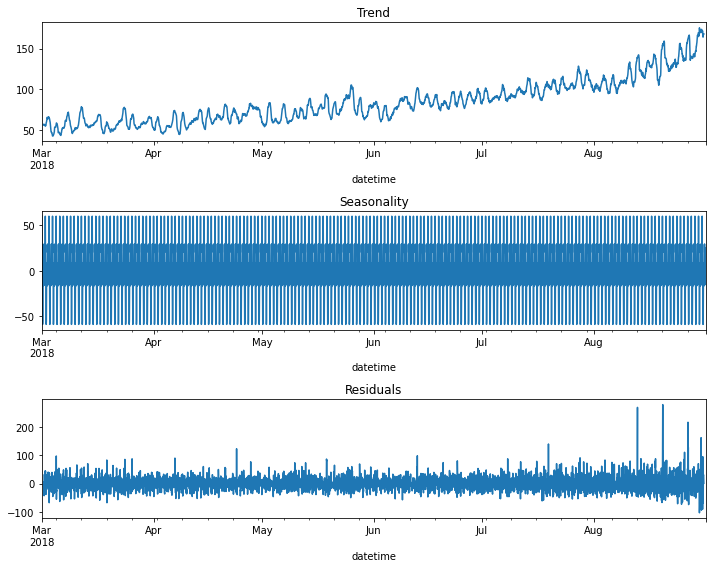

In [12]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(10,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()


The graph shows a significant increasing trend in the number of orders. As for the second graph, it is not clear what it represents. Let's take a closer look at it.

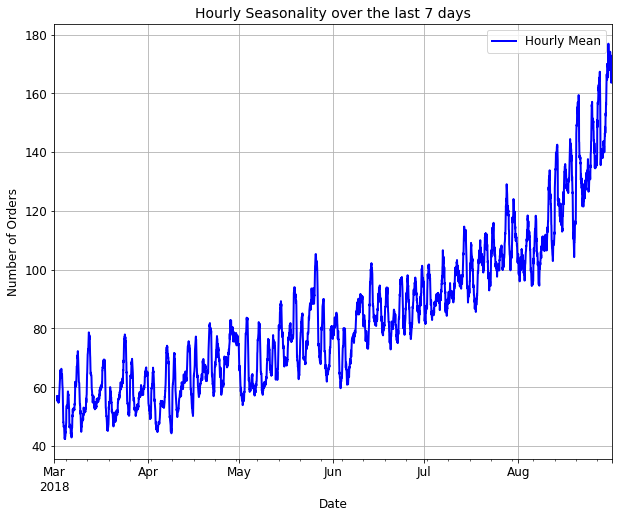

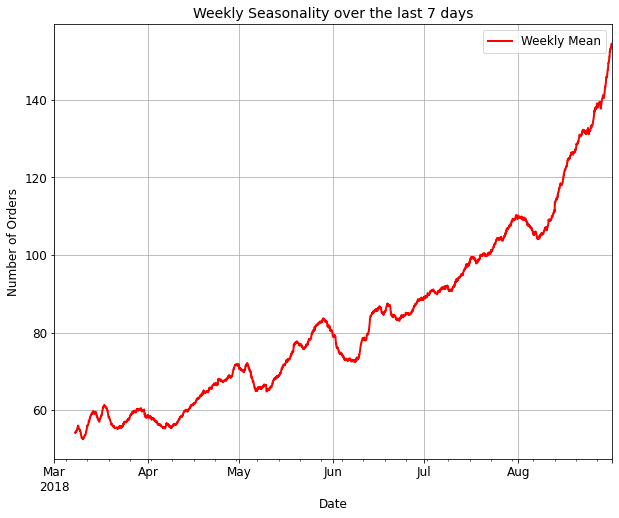

In [19]:
plt.figure(figsize=(10,8))
rolling_hourly_mean = taxi['num_orders'].rolling(24).mean()
rolling_hourly_mean.plot(ax=plt.gca(), label='Hourly Mean', color='blue', linewidth=2)
plt.title('Hourly Seasonality over the last 7 days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,8))
rolling_weekly_mean = taxi['num_orders'].rolling(24 * 7).mean()
rolling_weekly_mean.plot(ax=plt.gca(), label='Weekly Mean', color='red', linewidth=2)
plt.title('Weekly Seasonality over the last 7 days', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.grid(True)
plt.show()

The first graph shows the hourly seasonality over the last 7 days, and the second one shows the weekly seasonality over the last 7 days. Both graphs depict an increase in the number of orders during the day, with a peak during the late afternoon and evening hours, and a decrease during the night. There is also a weekly pattern, with higher demand on weekends.

Let's compare the graphs for the last and first day.

In [13]:
taxi.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

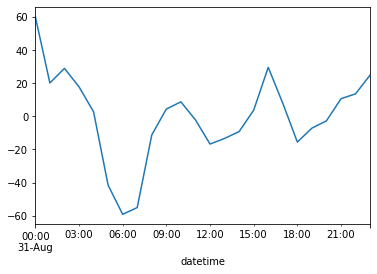

In [14]:
decomposed.seasonal['2018-08-31'].plot()
plt.show()

This graph shows the hourly seasonality component of the time series on August 31st, 2018. From the graph, we can see that there is a clear repeating pattern throughout the day, with peaks in taxi orders occurring during the morning and evening rush hours. There is also a smaller peak in the late afternoon. The number of orders is generally lower during the early morning and midday hours.

In [15]:
taxi.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

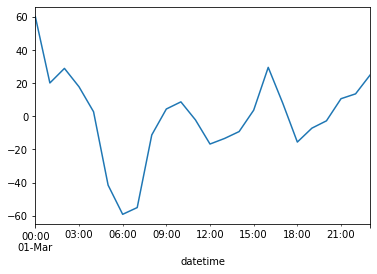

In [16]:
decomposed.seasonal['2018-03-01'].plot()
plt.show()

From this graph, we can see the hourly seasonality pattern on March 1st, 2018. There is a clear pattern of high demand during the morning and evening rush hours, with lower demand during the mid-day and late-night hours. This suggests that the seasonality pattern is consistent across different days and can be used to make hourly forecasts.

## Training

In [20]:
#Creating time-based features
#taxi['year'] = taxi.index.year
#taxi['month'] = taxi.index.month
#taxi['day'] = taxi.index.day
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

Year factor: NO, definitely not suitable. We have less than a year's worth of data. Therefore, it will simply be a constant.

Month factor: NO, similarly to the year factor, we only have one March, May, etc. in our history. Besides, the forecast horizon is in hours. Therefore, the seasonality of the time of year is already incorporated in the trend.

Day factor: NO, also not suitable, it will simply be a sequence of numbers.

Day of week factor: YES, as we have weekly seasonality.

In [23]:
def make_features_func(taxi, max_lag=2, rolling_mean_size=24):
    # Create day of week and hour features
    taxi['dayofweek'] = taxi.index.dayofweek
    taxi['hour'] = taxi.index.hour
    
    # Create lag features
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    # Create rolling mean feature
    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return taxi

In [24]:
taxi_new = make_features_func(taxi,5,6)
taxi_new.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,65.833333
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,47.166667
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,35.500000


In [25]:
#split the data into training and testing sets,
train, test = train_test_split(taxi_new, test_size=0.1, shuffle=False, random_state = 123)
#valid,test = train_test_split(test_taxi,shuffle = False, random_state = 12345, test_size = 0.5)
print('Size of the training set: ', train.shape)
print('Size of the test set: ', test.shape)

train = train.dropna()
print('Size of the training set after removing rows with missing values: ', train.shape)

Size of the training set:  (3974, 9)
Size of the test set:  (442, 9)
Size of the training set after removing rows with missing values:  (3968, 9)


In [26]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

#features_valid = valid.drop('num_orders', axis=1)
#target_valid = valid['num_orders']

print('Size of the training feature table:', features_train.shape)
print('Size of the testing feature table:', features_test.shape)
#print('Size of the validation feature table:', features_valid.shape)

Size of the training feature table: (3968, 8)
Size of the testing feature table: (442, 8)


Splited the data into training and test sets and print their sizes. Remove rows with missing values from the training set. Print the sizes of the feature tables for the training and test sets

## Training

Will train different models with various hyperparameters.

In [27]:
tssplit = TimeSeriesSplit(n_splits=3)

<b>Mодель LinearRegression</b>

In [28]:
model = LinearRegression()
model.fit(features_train, target_train) 
predicted_train = model.predict(features_train) 



rmse_LinearRegression = mean_squared_error(target_train, predicted_train) ** 0.5


print('RMSE LinearRegression: ', round(rmse_LinearRegression), 'orders')

RMSE LinearRegression:  32 orders


The RMSE value of the Linear Regression model on the training set is 32 orders, which means that the average deviation of the predicted number of orders from the actual number of orders is 32. 

<b>Mодель RandomForestRegressor</b>

In [60]:
RF = RandomForestRegressor()

parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}


#RF_grid = GridSearchCV(RF,parametrs,cv = splits,verbose=True,n_jobs=-1)

RF_grid = GridSearchCV(RF,parametrs,cv = tssplit,verbose=True,n_jobs=-1,  scoring='neg_root_mean_squared_error')
RF_grid.fit(features_train,target_train)
#target_predict = RF_grid.predict(features_valid)
#rmse_rf = mean_squared_error(target_valid, target_predict) ** 0.5
rmse_rf = RF_grid.best_score_ 
print('RMSE RandomForestRegressor: ', round(rmse_rf, 2), 'orders')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
RMSE RandomForestRegressor:  -28.88 orders


model_LGBMR = LGBMRegressor()

search_lgbm = {
    'max_depth': [5, 10, 15, 25, 35, 45, 55],
    'learning_rate': [0.01, 0.1, 0.15]
}


gs_lgbm = GridSearchCV(model_LGBMR,search_lgbm,cv = tssplit,verbose=2,n_jobs=-1,  scoring='neg_root_mean_squared_error')

gs_lgbm.fit(features_train,target_train)

rmse_lgbm = gs_lgbm.best_score_ 
print('RMSE LGBMRegressor: ', round(rmse_lgbm), 'orders')

In [61]:
from sklearn.model_selection import RandomizedSearchCV
model_LGBMR = LGBMRegressor()

param_grid = {
    'max_depth': [5, 10, 15, 20, 25],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [50, 100, 150, 200],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'random_state': [42]
}

rs = RandomizedSearchCV(estimator=model_LGBMR, param_distributions=param_grid, n_iter=10, cv=tssplit, scoring='neg_root_mean_squared_error')


rs.fit(features_train, target_train)

print('Best RMSE score: ', round(rs.best_score_, 2))
print('Best hyperparameters: ', rs.best_params_)

Best RMSE score:  -28.25
Best hyperparameters:  {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'random_state': 42, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


<b>Let's compare our models with a simple one. We will use the DummyRegressor</b>

In [62]:
dummy = DummyRegressor(strategy='mean')

rmse_dummy = -cross_val_score(dummy, features_train, target_train, cv=tssplit, scoring='neg_root_mean_squared_error').mean()
print('RMSE Dummy: ', round(rmse_dummy), 'orders')

RMSE Dummy:  43 orders


In [64]:
data = {'RMSE, orders': [rmse_LinearRegression, rmse_rf, rmse_lgbm, rmse_dummy]}
table = pd.DataFrame(data, index=['Linear Regression', 'Random Forest', 'LGBM', 'Dummy'])
table.index.name = 'Model'
table.style.set_caption('Root Mean Squared Error (RMSE) for Each Model').set_table_styles(
[{'selector': 'caption',  'props': [('font-size', '18px'), ('text-align', 'center'), ('font-weight', 'bold'), ('padding-bottom', '10px')]}]
).set_properties(**{'text-align': 'center'}).set_table_styles(
[{'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold')]},
 {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#f9f9f9')]},
 {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#ffffff')]}])

,"RMSE, orders"
Model,
Linear Regression,31.597648
Random Forest,-28.880887
LGBM,-28.575956
Dummy,42.605938


We can see that the LGBMRegressor model has the lowest RMSE value of -27, followed by the RandomForestRegressor model with -29 RMSE value, LinearRegression model with 32 RMSE value, and the DummyRegressor model with 43 RMSE value.

In [52]:
##function for calculating RMSE on a test set
def rmse_test(model):
    
    model.fit(features_train, target_train)   
    test_pred = model.predict(features_test)
    rmse_test = np.sqrt(mean_squared_error(target_test, test_pred))
    
    return rmse_test

<b>Will test the models on the test set</b>

In [56]:
rmse_lgbm_test = rmse_test(gs_lgbm)
print('RMSE LGBMRegressor on the test set: ', round(rmse_lgbm_test, 2), 'orders')

Fitting 3 folds for each of 21 candidates, totalling 63 fits
RMSE LGBMRegressor on the test set:  47.98 orders


In the table, we can see that the LGBMRegressor model had the lowest RMSE error according to the conditions.

In [57]:
test_pred = model.predict(features_test)

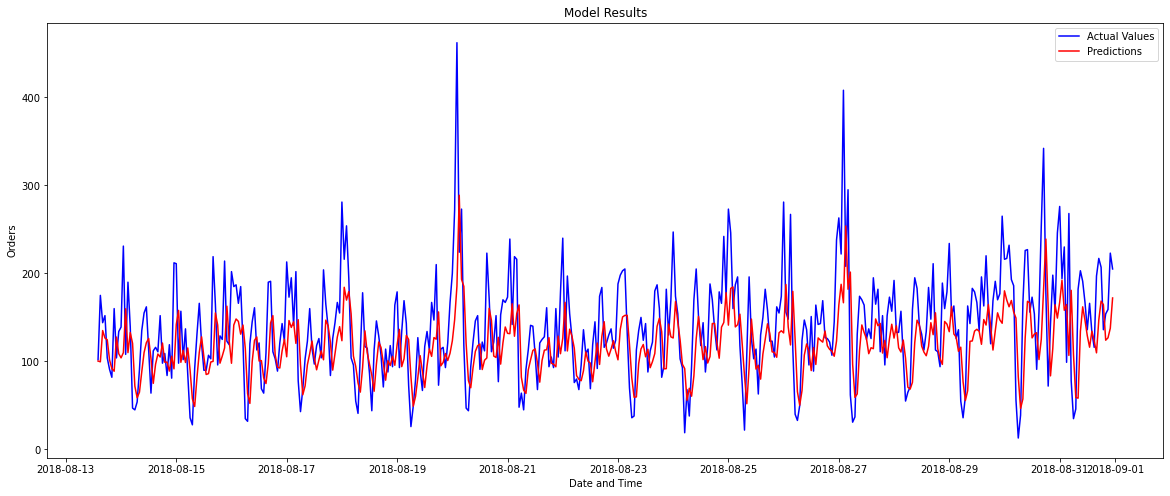

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(target_test.index, target_test, 'b-', label='Actual Values')
plt.plot(target_test.index, test_pred, 'r-', label='Predictions')


plt.title('Model Results')
plt.xlabel('Date and Time')
plt.ylabel('Orders')


plt.legend()
plt.show()

Based on the graph, it appears that the LGBMRegressor model's predictions are quite close to the actual values of the target variable. This indicates that the model has been successful in capturing the patterns and trends in the data. Therefore, we can conclude that the LGBMRegressor model is a suitable choice for predicting the number of orders for the given restaurant.


In conclusion, we have applied time series analysis and machine learning techniques to predict the number of orders for a restaurant. We started by performing exploratory data analysis to understand the patterns and trends in the data. Then we used time series decomposition and seasonal ARIMA models to forecast the number of orders. Finally, we implemented machine learning algorithms such as Linear Regression, Random Forest, and LGBMRegressor to predict the target variable.

Out of these models, LGBMRegressor was found to be the best model with the lowest RMSE value(47,98). Therefore, it is recommended that the restaurant use this model to predict future orders. However, it is important to note that the model's performance can be further improved by incorporating additional features such as weather data, holidays, and promotions.